## Raytracing with Dijkstra

Welcome to the notebook on raytracing based on Dijkstra's algorithm!

In [12]:
using Plots, PlutoUI, LinearAlgebra, STMO, DataStructures

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling PlutoUI [7f904dfe-b85e-4ff6-b463-dae2292396a8]
└ @ Base loading.jl:1278
┌ Info: Precompiling STMO [3ace5234-8ecc-46a3-bb23-1fccb8667e7a]
└ @ Base loading.jl:1278


In [2]:
struct Pixel
    x::Int
    y::Int
    ior::Float64
end
Pixel(x,y) = Pixel(x,y,1.0)

Pixel

In [3]:
h, w = 20,30
pixel_nodes = Dict()
for i = 1:h
    for j=1:w
        pixel_nodes[Pixel(i, j)] = []
        
        if j < w
            push!(pixel_nodes[Pixel(i,j)], (1, Pixel(i, j+1)))
            # Diagonals
            if i < h
                push!(pixel_nodes[Pixel(i,j)], (sqrt(2), Pixel(i+1, j+1)))
            end
            if i > 1
                push!(pixel_nodes[Pixel(i,j)], (sqrt(2), Pixel(i-1, j+1)))
            end
            
        end
        
        if j > 1
            push!(pixel_nodes[Pixel(i,j)], (1, Pixel(i, j-1)))
            # Diagonals
            if i < h
                push!(pixel_nodes[Pixel(i,j)], (sqrt(2), Pixel(i+1, j-1)))
            end
            
            if i > 1
                push!(pixel_nodes[Pixel(i,j)], (sqrt(2), Pixel(i-1, j-1)))
            end
        end
        
        # Left and right
        if i < h
           push!(pixel_nodes[Pixel(i,j)], (1, Pixel(i+1, j))) 
        end
        
        if i > 1
            push!(pixel_nodes[Pixel(i,j)], (1, Pixel(i-1, j)))
        end
    end
end

In [4]:
"""
    dijkstra(graph::AdjList{R,T}, source::T, sink::T) where {R<:Real,T}

Dijkstra's shortest path algorithm.

Inputs:
    - `graph` : adjacency list representing a weighted directed graph
    - `source`
    - `sink`

Outputs:
    - the shortest path
    - the cost of this shortest path
"""
function dijkstra(graph, source, sink)
    # initialize the tentative distances
    distances = Dict(v => Inf for v in keys(graph))
    distances[source] = 0
    previous = Dict()
    pq = PriorityQueue()
    enqueue!(pq, source, 0)
    while length(pq) > 0
        u = dequeue!(pq)
        u == sink && break
        
        for (dist_to_v, v) in graph[u]
            alternative = distances[u] + dist_to_v
            if alternative < distances[v]
                distances[v] = alternative
                previous[v] = u
                pq[v] = alternative
            end
        end
    end
    return distances, previous
end


dijkstra

In [5]:
"""
    reconstruct_path(previous::Dict{T,T}, source::T, sink::T) where {T}

Reconstruct the path from the output of the Dijkstra algorithm.

Inputs:
        - previous : a Dict with the previous node in the path
        - source : the source node
        - sink : the sink node
Ouput:
        - the shortest path from source to sink
"""
function reconstruct_path(previous, source, sink)
    if source ∉ values(previous)
        return []
    end
    v = sink
    path = [v]
    while v != source
       v = previous[v] 
        pushfirst!(path, v)
    end
    return path
end

reconstruct_path

In [6]:
function plot_pixels(adj_list, plot_dots=true, plot_edges=false, paths=nothing)
    pixels = [(pixel.x, pixel.y) for pixel in keys(adj_list)]
    w, h = maximum(first.(pixels)), maximum(last.(pixels))
    p = plot(xticks = round.(LinRange(0, w+1, 10)), xlims = (0,w+1),
            yticks=round.(LinRange(0, h+1, 10)), ylims=(0,h+1), legend=false)
    
    # Plot connecting edges
    if plot_edges
        for (pixel, pixel_list) in adj_list
            for p in last.(pixel_list)
                plot!([pixel.x, p.x], [pixel.y, p.y], label=false, color=:black)
            end
        end    
    end
    
    # Plot a series of paths
    if paths != nothing
        for path in paths
            for (i, pixel) in enumerate(path[1:end-1])
                plot!([pixel.x, path[i+1].x], [pixel.y, path[i+1].y], label=false, color=:red, lw=3)
            end
        end
    end
    
    if plot_dots
        # Plot the dots
        plot!(first.(pixels), last.(pixels), seriestype = :scatter, markersize = 50/w)
    end
    p
end

plot_pixels (generic function with 4 methods)

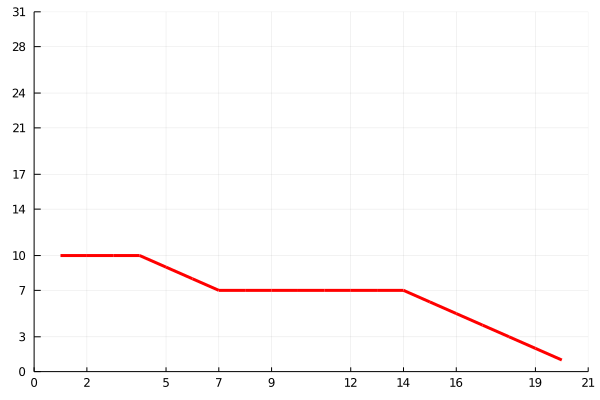

In [14]:
source, sink = Pixel(1,10), Pixel(20,1)
distances, previous = dijkstra(pixel_nodes, source, sink);
path = reconstruct_path(previous, source, sink)
plot_pixels(pixel_nodes, false, false, [path])